# Deep Learning para detección automática de COVID

En este proyecto, utilizaremos el dataset [COVID-19 Radiography Database](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/data) de Kaggle, es cual nos proporciona imágenes obtenidas mediante radiografías pertenecientes a tres tipos de pacientes diferentes: pacientes de control, sin ningún tipo de patoligía, pacientes de COVID-19 y pacientes con neumonía vírica.

*Nota: notebook adaptado y traducido del usuario de Kaggle [Ahmed Hafez](https://www.kaggle.com/code/ahmedtronic/covid-19-radiology-vgg19-f1-score-95)*

In [ ]:
# Nota: no hay por qué utilizar las librerías aquí puestas. Se pueden añadir/quitar
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from keras.applications import VGG16
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(42)
tf.random.set_seed(42)

La siguiente celda es para poder leer los datos directamente desde Google Colab. Si el alumno utiliza otra plataforma, se deberá saltar este paso y adaptar los PATHs a las carpetas de train y test.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


En la siguiente celda, se define el PATH a nuestros datos. Aquí debemos adaptarlo en función dónde lo tengamos guardado. Si tenemos nuestra carpeta con los materiales *Máster DL - IEP* en la página de inicio de nuestro Drive, el siguiente PATH debería valernos.

*Nota: si no se utiliza Google Colab, se pueden utilizar paths relativos.*

In [ ]:
PATH = "drive/MyDrive/Formaciones/Máster DL - IEP/ProyectoFinal/"

Tras haber importado las librerías necesarias, vamos a generar un código que nos permita preprocesar las imágenes. Para ello, creamos la función *generate_data()*, a la cual le pasaremos el directorio donde tenemos almacenadas las imágenes.

Aquí encontramos la clase *ImageDataGenerator*, que ya hemos utilizado en notebooks anteriores. Veamos paso a paso lo que hacemos dentro de la función. Lo primero, es crear el objeto de la clase *ImageDataGenerator*, con la línea

```
datagen = ImageDataGenerator(rescale=1./255.)
```

donde lo único que les estamos indicando es que nos reescale las imágenes, como ya hemos hecho durante el curso, haciendo que el valor de cada píxel vaya de 0 a 1 en lugar de ir desde 0 a 255. Aquí es donde debemos darnos cuenta de que no estamos llevando a cabo ningún tipo de *Data Augmentation*. Cuando queremos generar el flujo de imágenes para aplicar el generador a nuestras imágenes, usamos

```
generator = datagen.flow_from_directory(DIR,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        seed=42,
                                        class_mode='binary',
                                        target_size=(height, width),
                                        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2})
```

Donde los parámetros más importantes para nosotros son:

- DIR es la carpeta donde están nuestras imágenes, a las cuales se aplicará el generador que hemos creado.
- batch_size es el tamaño del batch, que hemos definido anteriormente como 64.
- shuffle=True nos indica que el orden de los datos será aleatorio.
- target_size es el tamaño al que queremos reescalar las imágenes para adaptarlo a nuestro modelo, en nuestro caso 224x244 píxeles.
- classes es un diccionario para asignar a cada clase una etiqueta numérica. Así, posteriormente podremos entrenar nuestra red neuronal.

Tras ello, aplicamos el generador a nuestros conjuntos de entrenamiento y de test, obteniendo *test_generator* y *train_generator*.


In [ ]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64

# Instancia de ImageDataGenerator con parámetros de aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


def generate_data(DIR):
    #datagen = ImageDataGenerator(rescale=1./255.)

    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='categorical',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = PATH + 'Covid19-dataset/train'
TESTING_DIR = PATH + 'Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


Una vez tengamos los generadores creados, procedemos a ver cuántas muestras tenemos de cada clase obteniendo 90 de la clase 'Normal', otros 90 de la clase 'Neumonía vírica' y 137 de la clase 'COVID'.

## Desarrollo del proyecto

A partir de aquí, todo queda a criterio del alumno. Se pueden desarrollar modelos con cualquiera de las herramientas vistas a lo largo del curso - regularización, técnicas de entrenamiento, transfer learning, data augmentation, etc.

*Nota: el código anterior también puede ser modificado si el alumno lo desea.*

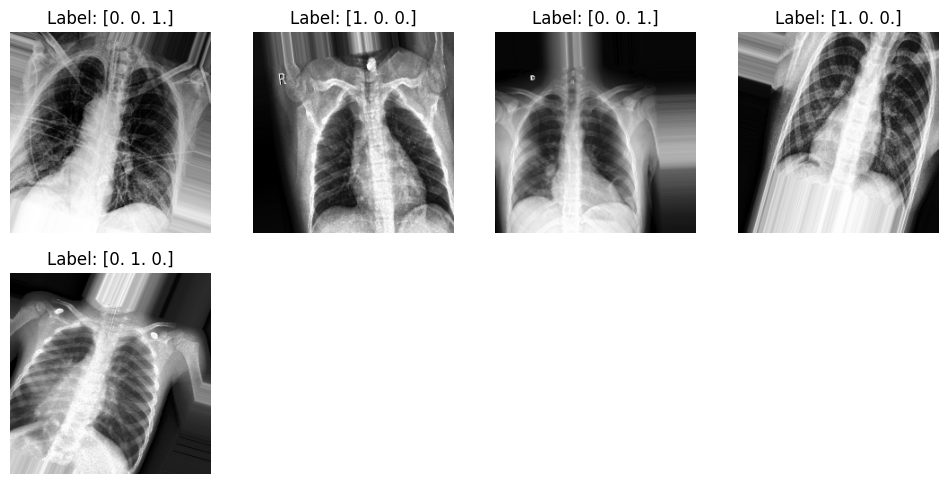

In [ ]:
# Visualizaremos algunas de las imagenees para ver el efecto de data augumentation
images, label =  next(train_generator)

plt.figure(figsize=(12, 12))
for i in range(5):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {label[i]}")
    plt.axis("off")

In [ ]:
# Definir el modelo de la red neuronal convolucional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

n_classes = 3
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))


# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con aumentación de datos
model.fit(train_generator, batch_size=64,epochs=20,validation_data=(test_generator))

# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.3381 - loss: 3.6416 - val_accuracy: 0.3182 - val_loss: 1.3410
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3878 - loss: 1.4544 - val_accuracy: 0.3939 - val_loss: 1.2339
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4336 - loss: 1.1534 - val_accuracy: 0.3333 - val_loss: 1.0780
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.3363 - loss: 1.0604 - val_accuracy: 0.4848 - val_loss: 0.9818
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6036 - loss: 0.9655 - val_accuracy: 0.5909 - val_loss: 0.8360
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7404 - loss: 0.7517 - val_accuracy: 0.7121 - val_loss: 0.7125
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7030 - loss: 0.6933 - val_accuracy: 0.6667 - val_loss: 0.8281
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7193 - loss: 0.6721 - val_accuracy: 0.6970 - val_loss: 0.5562
Epoch 9/

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8775 - loss: 0.3502
Test accuracy: 0.8787878751754761


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


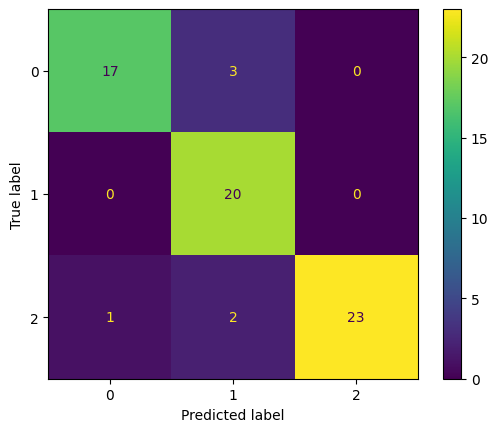

In [ ]:
# Creando lista para la matrix de confusion
etiquetas = []
predicciones = []

# Se esta resetenado para los lotes se ordenen y la iteracion no se salte uno ellos
test_generator.reset()

for i in range(len(test_generator)):
    images, labels = test_generator[i]
    predict = model.predict(images)
    etiquetas.extend(np.argmax(labels, axis=1))
    predicciones.extend(np.argmax(predict, axis=1))

# Estamos convirtiendo las lista en arreglos para su compatibilidad
etiquetas = np.array(etiquetas)
predicciones = np.array(predicciones)

cm = confusion_matrix(etiquetas, predicciones)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
# Resumen de metrcias del modelo
print(classification_report(etiquetas, predicciones))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.80      1.00      0.89        20
           2       1.00      0.88      0.94        26

    accuracy                           0.91        66
   macro avg       0.91      0.91      0.91        66
weighted avg       0.92      0.91      0.91        66



In [ ]:
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224,3)))
model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))
model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.5))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(n_classes, activation='softmax'))


# Compilar el modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con aumentación de datos
model1.fit(train_generator, batch_size=64,epochs=20,validation_data=(test_generator))

# Evaluar el modelo
test_loss, test_acc = model1.evaluate(test_generator)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 68s 12s/step - accuracy: 0.3402 - loss: 12.7979 - val_accuracy: 0.3030 - val_loss: 1.0854
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3105 - loss: 1.2582 - val_accuracy: 0.3939 - val_loss: 1.0988
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4576 - loss: 1.0717 - val_accuracy: 0.3939 - val_loss: 1.0907
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4555 - loss: 1.0459 - val_accuracy: 0.6061 - val_loss: 1.0528
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4428 - loss: 0.9799 - val_accuracy: 0.5455 - val_loss: 0.9425
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6224 - loss: 0.8019 - val_accuracy: 0.5455 - val_loss: 0.8506
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6434 - loss: 0.6971 - val_accuracy: 0.5152 - val_loss: 0.9013
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7014 - loss: 0.7274 - val_accuracy: 0.5909 - val_loss: 0.8467
Epoch 

In [ ]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224,3)))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.5))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(n_classes, activation='softmax'))


# Compilar el modelo
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con aumentación de datos
model2.fit(train_generator, batch_size=64,epochs=20,validation_data=(test_generator))

# Evaluar el modelo
test_loss, test_acc = model2.evaluate(test_generator)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.3402 - loss: 3.0144 - val_accuracy: 0.3030 - val_loss: 1.0981
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.2658 - loss: 1.1462 - val_accuracy: 0.3939 - val_loss: 1.0956
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4109 - loss: 1.0868 - val_accuracy: 0.3939 - val_loss: 1.0947
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4429 - loss: 1.0789 - val_accuracy: 0.3939 - val_loss: 1.0834
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4531 - loss: 1.0489 - val_accuracy: 0.3939 - val_loss: 1.0666
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4890 - loss: 1.0101 - val_accuracy: 0.5152 - val_loss: 0.9845
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6149 - loss: 0.8681 - val_accuracy: 0.5152 - val_loss: 0.8637
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6592 - loss: 0.7446 - val_accuracy: 0.5152 - val_loss: 1.1684
Epoch 9/

In [ ]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224,3)))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(n_classes, activation='softmax'))


# Compilar el modelo
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con aumentación de datos
model3.fit(train_generator, batch_size=64,epochs=20,validation_data=(test_generator))

# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.3150 - loss: 4.1756 - val_accuracy: 0.3939 - val_loss: 1.0769
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4179 - loss: 1.1368 - val_accuracy: 0.4091 - val_loss: 1.0909
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4792 - loss: 1.0740 - val_accuracy: 0.3939 - val_loss: 1.0738
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4765 - loss: 1.0323 - val_accuracy: 0.5303 - val_loss: 1.0004
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5577 - loss: 0.9305 - val_accuracy: 0.5303 - val_loss: 0.9472
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5586 - loss: 0.9569 - val_accuracy: 0.5606 - val_loss: 0.9031
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5215 - loss: 0.8909 - val_accuracy: 0.6061 - val_loss: 0.9912
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5559 - loss: 0.8883 - val_accuracy: 0.5455 - val_loss: 0.9308
Epoch 9/

In [ ]:
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224,3)))
model4.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(BatchNormalization())
model4.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model4.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(BatchNormalization())
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(n_classes, activation='softmax'))


# Compilar el modelo
model4.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con aumentación de datos
model4.fit(train_generator, batch_size=64,epochs=20,validation_data=(test_generator))

# Evaluar el modelo
test_loss, test_acc = model4.evaluate(test_generator)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.4309 - loss: 1.1521 - val_accuracy: 0.3030 - val_loss: 1.1350
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.6856 - loss: 0.7423 - val_accuracy: 0.3333 - val_loss: 1.1003
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7193 - loss: 0.6399 - val_accuracy: 0.3485 - val_loss: 1.1001
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7048 - loss: 0.6232 - val_accuracy: 0.4242 - val_loss: 1.0733
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7304 - loss: 0.6194 - val_accuracy: 0.3939 - val_loss: 1.0643
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7790 - loss: 0.5360 - val_accuracy: 0.3939 - val_loss: 1.0575
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7607 - loss: 0.5341 - val_accuracy: 0.3939 - val_loss: 1.0586
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7999 - loss: 0.5123 - val_accuracy: 0.3939 - val_loss: 1.0617
Epoch 9/

In [ ]:
model5 = Sequential()
model5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224,3)))
model5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(BatchNormalization())
model5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(BatchNormalization())
model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dense(256, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dense(256, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dense(n_classes, activation='softmax'))


# Compilar el modelo
model5.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con aumentación de datos
model5.fit(train_generator, batch_size=64,epochs=20,validation_data=(test_generator))

# Evaluar el modelo
test_loss, test_acc = model5.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5538 - loss: 1.0534 - val_accuracy: 0.3030 - val_loss: 1.1460
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7773 - loss: 0.5481 - val_accuracy: 0.3182 - val_loss: 1.1126
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.7749 - loss: 0.5509 - val_accuracy: 0.3485 - val_loss: 1.0940
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8157 - loss: 0.4565 - val_accuracy: 0.3939 - val_loss: 1.0859
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8070 - loss: 0.4480 - val_accuracy: 0.3939 - val_loss: 1.0856
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8339 - loss: 0.4060 - val_accuracy: 0.3939 - val_loss: 1.0877
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8969 - loss: 0.2666 - val_accuracy: 0.3939 - val_loss: 1.0915
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8212 - loss: 0.4050 - val_accuracy: 0.3939 - val_loss: 1.0991
Epoch 9/

In [ ]:
model6 = Sequential()
model6.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224,3)))
model6.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.5))
model6.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model6.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.5))
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.5))
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.5))
model6.add(Dense(n_classes, activation='softmax'))


# Compilar el modelo
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con aumentación de datos
model6.fit(train_generator, batch_size=64,epochs=20,validation_data=(test_generator))

# Evaluar el modelo
test_loss, test_acc = model6.evaluate(test_generator)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.3189 - loss: 1.9995 - val_accuracy: 0.3939 - val_loss: 1.0934
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4146 - loss: 1.1053 - val_accuracy: 0.3939 - val_loss: 1.0963
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4273 - loss: 1.0895 - val_accuracy: 0.3939 - val_loss: 1.0920
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3937 - loss: 1.0875 - val_accuracy: 0.3939 - val_loss: 1.0841
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4515 - loss: 1.0787 - val_accuracy: 0.3939 - val_loss: 1.0812
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4062 - loss: 1.0779 - val_accuracy: 0.3939 - val_loss: 1.0693
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4305 - loss: 1.0703 - val_accuracy: 0.3939 - val_loss: 1.0533
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4196 - loss: 1.0334 - val_accuracy: 0.3939 - val_loss: 1.0175
Epoch 9/

### Observaciones:

* En esta parte del proyecto se utilizo la tecnica data augmentacion del modulo ImagiDataGenerator con el objetivo de aumentar la cantidad de datos y a su mejorar la calidad y presicion de los modelos o redes neuronales.

* El primer modelo fue el mas simple sin embargo uno de los que mejores resultados arrojo. No se utilizaron funcioes de activacion en la capas ocultas ni luego de las convd2 y maxspooling para ver el comportamiento del modelo. Este alcanzo una presicion de un 87% de acierto una pedida de hasta 40% que para ser tan simple, en relacion con los demas arrojo muy buenos resultados.

* En el segundo modelo, auque se incorporaron funciones de activacionesy mas capas convolucionales y maxpooling el rendimiento del modelo en cuanto a presicion disminuyo un 10%. Aunque en el primer modelo no presento sobre ajuste queria ver el impacto que tenia su aplicacion.

* En el tercer modelo se procedio a incorpor la cantidad de capas densas y cantidad de neuronas en las mismas para ver su impacto el cual no fue nada positvo ya que la calidad del modelo continuo disminuynedo hasta un 45% en su presicion. Entendia que tendria un impacto mas positivo pero fue todo lo contrario.

* En el cuarto, construyendo encima del anterior, a diferencia del tercero, se incorporaron dos capas adicionales de dropout para la regularizar las capas de densas antes de la capa de salida. Este modelo con esta arquitectura incremento su capacidad de acierto en 72%, 10 puntos mayor que el anterior. Estos nos que 7 de 10 clasificaciones son correctas.

* En los demas realizamos combinaciones de funciones de activaciones, numeros de neuronas en la capas, funciones de relurizacion.

* Los modelos presentaron mejor rendimiento con funciones de regularazacion, para ser mas especifico con dropout.


### Matrix de confusion

* Aqui podemos confirmar que el modelos tiene muy buen acierto, un 91% a nivel general. En cuanto a los clase 0, que representan a los personas sanas, tiene un nivel de acierto de 94%, entiendo es que  muy bueno. Ademas, de todos los casos que eran reales de esta clase, acerto con 85%, es muy interesanto que casi presento falsos positivos. La clase 1, que representa las personas con nuemonia virica, tiene un acierto de un 80% las mas bajas de todas.  En cuanto a la clase 2, que representan a las personas con covid, en acierto presento un 100% y en casos reales un 88% de acierto, muy esta metrica.



## Transfer Learning para clasificación de imágenes de COVI19

In [ ]:
# Cargar el modelo VGG16 pre-entrenado sin la capa de clasificación
base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Congelar las capas del modelo base
for layer in base_model.layers:
        layer.trainable = False

In [ ]:
# Creando la ultima capa del modelo para entrenarla
x  = Flatten()(base_model.output)
x  = Dense(512, activation='relu')(x)
x  = Dropout(0.5)(x)
x  = Dense(512, activation='relu')(x)
x  = Dropout(0.5)(x)
x  = Dense(512, activation='relu')(x)
x  = Dropout(0.5)(x)
predict = Dense(3, activation='softmax')(x)

In [ ]:
# Definir el modelo secuencial sobre el modelo base
model = keras.models.Model(inputs=base_model.input, outputs=predict)

In [ ]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
history = model.fit(
      train_generator,
      batch_size=64,
      epochs=20,
      validation_data=(test_generator),
)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8068 - loss: 0.4958 - val_accuracy: 0.8182 - val_loss: 0.3714
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8089 - loss: 0.4566 - val_accuracy: 0.8939 - val_loss: 0.3604
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8005 - loss: 0.5231 - val_accuracy: 0.8939 - val_loss: 0.3631
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7744 - loss: 0.5050 - val_accuracy: 0.8939 - val_loss: 0.3332
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8337 - loss: 0.4233 - val_accuracy: 0.8788 - val_loss: 0.3231
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8331 - loss: 0.4066 - val_accuracy: 0.8788 - val_loss: 0.2768
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8182 - loss: 0.4190 - val_accuracy: 0.8485 - val_loss: 0.3161
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8269 - loss: 0.4149 - val_accuracy: 0.8788 - val_loss: 0.3204
Epoch 9/

In [ ]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

2/2 - 2s - 846ms/step - accuracy: 0.8939 - loss: 0.2762

Test accuracy: 0.8939393758773804


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


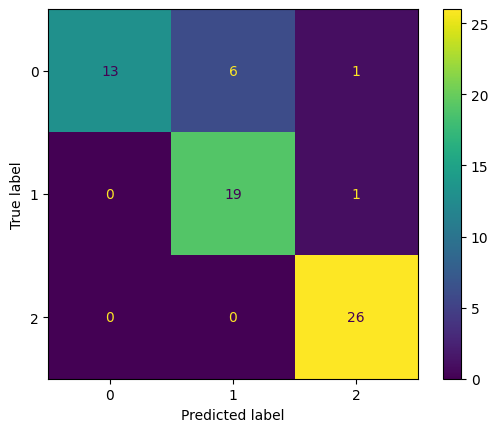

In [ ]:
# Creando lista para la matrix de confusion
etiquetas = []
predicciones = []

# Se esta resetenado para los lotes se ordenen y la iteracion no se salte uno ellos
test_generator.reset()

for i in range(len(test_generator)):
    images, labels = test_generator[i]
    predict = model.predict(images)
    etiquetas.extend(np.argmax(labels, axis=1))
    predicciones.extend(np.argmax(predict, axis=1))

# Estamos convirtiendo las lista en arreglos para su compatibilidad
etiquetas = np.array(etiquetas)
predicciones = np.array(predicciones)

cm = confusion_matrix(etiquetas, predicciones)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
# Resumen de metrcias del modelo
print(classification_report(etiquetas, predicciones))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        20
           1       0.71      1.00      0.83        20
           2       1.00      1.00      1.00        26

    accuracy                           0.88        66
   macro avg       0.90      0.87      0.86        66
weighted avg       0.91      0.88      0.87        66



## Fine tuning para clasificación de imágenes de COVI19

In [ ]:
# Cargar el modelo VGG16 pre-entrenado sin la capa de clasificación
base_model1 = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Creando la ultima capa del modelo para entrenarla
x  = Flatten()(base_model1.output)
x  = Dense(512, activation='relu')(x)
x  = Dropout(0.5)(x)
x  = Dense(512, activation='relu')(x)
x  = Dropout(0.5)(x)
x  = Dense(512, activation='relu')(x)
x  = Dropout(0.5)(x)
predict = Dense(3, activation='softmax')(x)

In [ ]:
# Definir el modelo secuencial sobre el modelo base
model1 = keras.models.Model(inputs=base_model1.input, outputs=predict)

In [ ]:
# Compilar el modelo
model1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
history = model1.fit(
      train_generator,
      batch_size=64,
      epochs=20,
      validation_data=(test_generator),
)

# Evaluar el modelo
test_loss, test_acc = model1.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 262s 53s/step - accuracy: 0.3872 - loss: 1.2224 - val_accuracy: 0.3939 - val_loss: 1.0761
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4006 - loss: 1.2017 - val_accuracy: 0.3939 - val_loss: 1.0454
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4226 - loss: 1.0914 - val_accuracy: 0.6364 - val_loss: 0.9946
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4743 - loss: 1.0301 - val_accuracy: 0.5909 - val_loss: 0.8778
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5719 - loss: 0.9016 - val_accuracy: 0.5152 - val_loss: 0.8289
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5375 - loss: 0.9098 - val_accuracy: 0.6515 - val_loss: 0.6948
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5408 - loss: 0.8331 - val_accuracy: 0.6667 - val_loss: 0.6480
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5628 - loss: 0.8651 - val_accuracy: 0.6364 - val_loss: 0.7025
Epoch 

In [ ]:
# Cargar el modelo VGG16 pre-entrenado sin la capa de clasificación
base_model2 = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
)

In [ ]:
# Creando la ultima capa del modelo para entrenarla
x  = Flatten()(base_model2.output)
x  = Dense(512, activation='relu')(x)
x  = Dropout(0.5)(x)
x  = Dense(512, activation='relu')(x)
x  = Dropout(0.5)(x)
predict = Dense(3, activation='softmax')(x)

In [ ]:
# Definir el modelo secuencial sobre el modelo base
model2 = keras.models.Model(inputs=base_model2.input, outputs=predict)

In [ ]:
# Funcion de regularizacion early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
)

In [ ]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
history = model2.fit(
      train_generator,
      batch_size=64,
      epochs=50,
      validation_data=(test_generator),
      callbacks=[early_stopping]
)

# Evaluar el modelo
test_loss, test_acc = model2.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.3291 - loss: 2.7500 - val_accuracy: 0.3030 - val_loss: 1.0977
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.3329 - loss: 1.1228 - val_accuracy: 0.3030 - val_loss: 1.1648
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.4137 - loss: 1.1423 - val_accuracy: 0.3939 - val_loss: 1.0952
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4216 - loss: 1.0903 - val_accuracy: 0.3939 - val_loss: 1.0883
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.4515 - loss: 1.0714 - val_accuracy: 0.3939 - val_loss: 1.0807
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4167 - loss: 1.0909 - val_accuracy: 0.3939 - val_loss: 1.0805
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.4462 - loss: 1.1737 - val_accuracy: 0.3939 - val_loss: 1.1000
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4269 - loss: 1.2381 - val_accuracy: 0.3030 - val_loss: 1.1166
Epoch 9/

## Observaciones:

* En esta otra parte del proyecto, queria aplicar las tecnicas Transfer learning y Fine tuning ya que entiendo que las condiciones del dataset de su disponibilidad de pocos datos aplica, quise construir dos redes con estas dos tecnicas aplicando tambien Data augmentation. Lo hago de esta manera simplemente por curiosidad y pasion por este campo.

#### Transfer learning

* El primer modelo creado fue con Trasnfer learning en el cual tuvimos un muy un rendimiento cerca de un 90% de presicion, el cual supero por mas de 14% el mejor utilizando, en la primera parte, donde solo utilizamos data augumentation.

* La arquitectura utilizada en la ultima capa, la cual solo podemos modificar con este tipo de tecnica,6 capas, a parte de las capas flatten y de salida, 3 densa con 512 neuronas con la funcion de activacion relu y con las fuciones de regularizacion dropout con una tasa de un 0.5 para el sobreajuste.

* Utilizamos el optimizador adam con una tasa de aprendizaje 0.0001 para el ajuste de los pesos con sus respectivas metricas. La funcion de perida utilizada fue categorical crossentropy, la cual ideal para casos multiclases como el nuestro y para medir su presicion utilizamos acurracy.

### Fine Tuning

* Para este caso utilizamos la misma arquitectura que con transfer learning, sin embargo, obtuvimo un 79% de acierto, 10% menor. A raiz de este caso probe con otra arquitectura, eliminando una capa densa y otra de regularzacion, para incluir otra funcion de regularizacion, early stopping, para que el modelo se detuviera en el momento que comenzara a disminuir su rendimiento, esto hice a razon de que vi en las epoch del entrenamiento un rendimiento hasta de un 84%, sin embargo el rendimiento del modelo fue por debajo del primer intento, con un 39% de acierto, muy bajo en comparacion con el anterior. Entiendo que puedo intentar con otras combinaciones funciones de activacion y regulirazion para mejorar el modelo o utilizar GridSearchCV para una mejor busquda de los hiperparametros del modelo.

### Matrix de confusion

* A nivel genereal el modelos aplciado con trasnfer learning tiene muy buen nivel de acierto en sus predicciones generales con 88% de acierto. En cuanto a la clase 0, que representa las personas sanas, tiene muy buen acierto de un 100% sin embargo, idetificando los casos reales un 60% muy bajo con relacion a las otras metricas. En cuanto a la clase 1, que representa las personas con neumonia virica, tiene un bajo acierto de sus predicciones con un 71% y un muy buen resultado con los casos reales con 100%. En la clase 2, se podria es la que esta mejor, se puede decir que todos los posibles caso, clasifica mejor las personas que tienen covid. entiendo que tiene un pequeño marjen de mejora pero en general tiene buen rendimiento el modelo.



### Conclusiones:

* Para este caso transfer learning dado su porcentaje de acierto de 90%.

* En los casos que combine las tecnicas data augmentation y transfer learning el nivel de acierto aumento hasta un 14% sin necesidad de realizar mucho mas intentos, casi un 90%. Entiendo que un modelo donde acierte 9 de 10 casos, y mas con casos que se relacionan con la salud, es muy bueno.

* Los modelos donde utilizo la funcion relu y dropout presentaron un mejor rendimiento que los demas.

* Utilizar tecnica como transfer learning y fine tuning son muy ventajosas ya que podemos alimnetar nuestros modelos con otros modelos que nos ayuda mucho al rendimiento del nuestro.



